In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from scipy.special import legendre
from photometry_functions import airPLS, get_zdFF

In [3]:
sns.set_style('ticks')
sns.set_context('talk')
import warnings; warnings.simplefilter('ignore')

In [4]:
data_dir = '/home/julia/data/ict/'

### Load one trial

In [10]:

mouse = 'UUU'
day= 0

#mouse = 'WEY'
#day = 1

df = pd.read_pickle(data_dir+'mice/{}.pkl'.format(mouse))

In [11]:
trial = 10
raw_signal = df[(df['day']==day)]['gpmt'].iloc[trial]
raw_reference = df[(df['day']==day)]['rpmt'].iloc[trial]

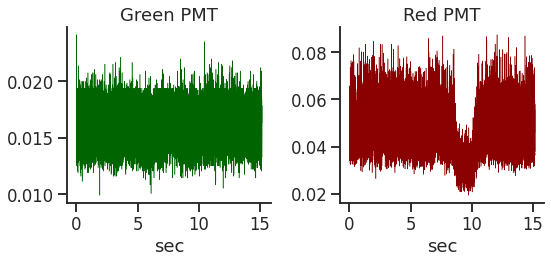

In [12]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(raw_signal,'darkgreen',linewidth=0.5)
ax1.set_xticks([0,5000,10000, 15000])
ax1.set_xticklabels([0,5,10,15])
ax1.set_xlabel('sec')
ax1.set_title('Green PMT')

ax2 = fig.add_subplot(122)
ax2.plot(raw_reference,'darkred',linewidth=0.5)
ax2.set_xticks([0,5000,10000, 15000])
ax2.set_xticklabels([0,5,10,15])
ax2.set_xlabel('sec')
ax2.set_title('Red PMT')

plt.tight_layout()
sns.despine()

# Step by step -- adapted

### Smooth

In [13]:
smooth_signal = gaussian_filter1d(raw_signal, sigma=100, output=np.float64)
smooth_reference = gaussian_filter1d(raw_reference, sigma=100, output=np.float64)

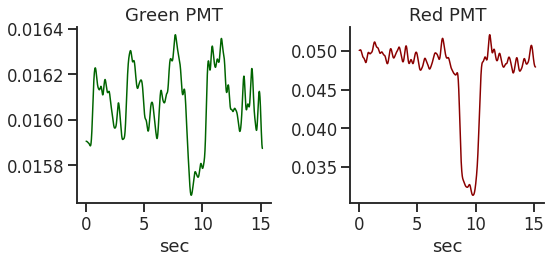

In [14]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(smooth_signal,'darkgreen',linewidth=1.5)
ax1.set_xticks([0,5000,10000, 15000])
ax1.set_xticklabels([0,5,10,15])
ax1.set_xlabel('sec')
ax1.set_title('Green PMT')

ax2 = fig.add_subplot(122)
ax2.plot(smooth_reference,'darkred',linewidth=1.5)
ax2.set_xticks([0,5000,10000, 15000])
ax2.set_xticklabels([0,5,10,15])
ax2.set_xlabel('sec')
ax2.set_title('Red PMT')
plt.tight_layout()
sns.despine()

### Remove beginning and end

In [177]:
remove = 1000
short_signal = smooth_signal[remove:-remove]
short_reference = smooth_reference[remove:-remove]

### Linear regression to fit baseline

In [178]:
predict_signal = airPLS(short_signal, lambda_=4e5, porder=1, itermax=50)
predict_reference = airPLS(short_reference, lambda_=4e5, porder=1, itermax=50)

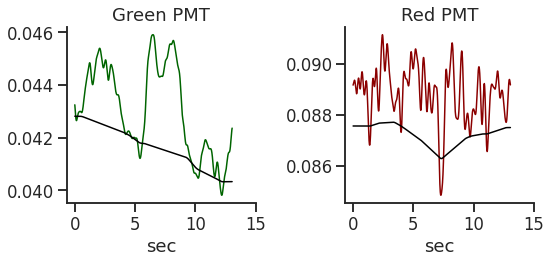

In [179]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(short_signal,'darkgreen',linewidth=1.5)
ax1.plot(predict_signal,'black',linewidth=1.5)
ax1.set_xticks([0,5000,10000, 15000])
ax1.set_xticklabels([0,5,10,15])
ax1.set_xlabel('sec')
ax1.set_title('Green PMT')


ax2 = fig.add_subplot(122)
ax2.plot(short_reference,'darkred',linewidth=1.5)
ax2.plot(predict_reference,'black',linewidth=1.5)
ax2.set_xticks([0,5000,10000, 15000])
ax2.set_xticklabels([0,5,10,15])
ax2.set_xlabel('sec')
ax2.set_title('Red PMT')

plt.tight_layout()
sns.despine()

### Remove baseline

In [180]:
signal = short_signal - predict_signal 
reference = short_reference - predict_reference

### Standardize signal

In [181]:
z_reference = (reference - np.median(reference)) / np.std(reference)
z_signal = (signal - np.median(signal)) / np.std(signal)

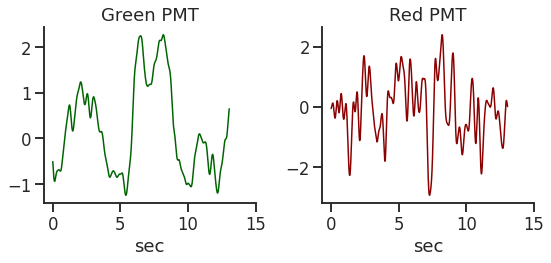

In [182]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(z_signal,'darkgreen',linewidth=1.5)
ax1.set_xticks([0,5000,10000, 15000])
ax1.set_xticklabels([0,5,10,15])
ax1.set_xlabel('sec')
ax1.set_title('Green PMT')


ax2 = fig.add_subplot(122)
ax2.plot(z_reference,'darkred',linewidth=1.5)
ax2.set_xticks([0,5000,10000, 15000])
ax2.set_xticklabels([0,5,10,15])
ax2.set_xlabel('sec')
ax2.set_title('Red PMT')
plt.tight_layout()
sns.despine()

### Fit signals using linear regression

from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
n = len(z_reference)
lin.fit(z_reference.reshape(n,1), z_signal.reshape(n,1))
z_reference_fitted = lin.predict(z_reference.reshape(n,1)).reshape(n,)

In [183]:
lin = LinearRegression()
n = len(z_reference)
lin.fit(z_reference.reshape(n,1), z_signal.reshape(n,1))
z_reference_fitted = lin.predict(z_reference.reshape(n,1)).reshape(n,)
zdFF = (z_signal - z_reference_fitted)

In [184]:
idx=np.arange(0,z_signal.shape[0],100)

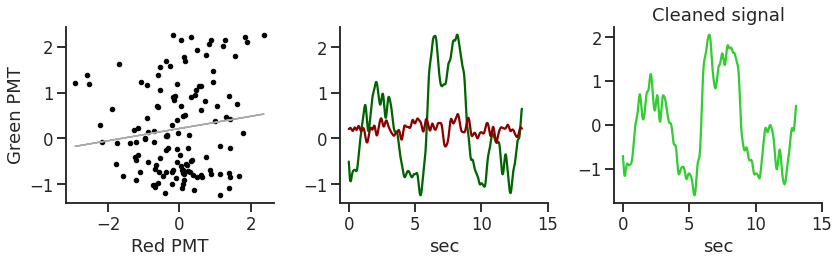

In [185]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(z_reference[idx],z_signal[idx],'k.', linewidth=0)
ax1.plot(z_reference[idx],z_reference_fitted[idx], color='darkgrey', 
         linewidth=1.5)
ax1.set_xlabel('Red PMT')
ax1.set_ylabel('Green PMT')

ax2 = fig.add_subplot(132)
ax2.plot(z_signal,'darkgreen', label='Green PMT')
ax2.plot(z_reference_fitted,'darkred', label='Fitted Red PMT')
ax2.set_xticks([0,5000,10000, 15000])
ax2.set_xticklabels([0,5,10,15])
ax2.set_xlabel('sec')
#plt.legend()

ax3 = fig.add_subplot(133)
ax3.plot(zdFF,'limegreen')
ax3.set_xticks([0,5000,10000, 15000])
ax3.set_xticklabels([0,5,10,15])
ax3.set_xlabel('sec')
ax3.set_title('Cleaned signal')

plt.tight_layout()
sns.despine()

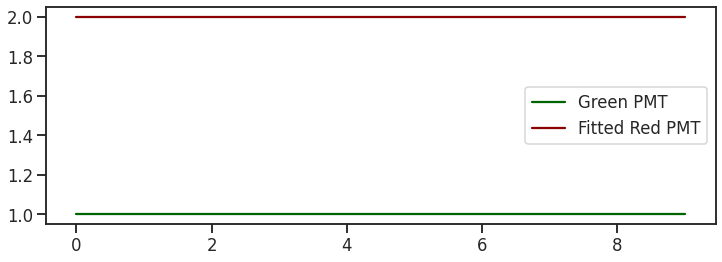

In [171]:
fig = plt.figure(figsize=(12,4))
plt.plot(np.ones(10), 'darkgreen', label='Green PMT')
plt.plot(np.ones(10)*2,'darkred', label='Fitted Red PMT')
plt.legend()